# 작사가 만들기
## RNN을 활용하여 작사가를 만들어보자!

In [33]:
import os, re 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob
import seaborn as sns

## 데이터 불러오기

In [3]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:10])

데이터 크기: 187088
Examples:
 ['[Hook]', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face [Verse 1]', "Somethin' ain't right when we talkin'"]


## 문장 전처리

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

## 정제된 문장 모음

In [5]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue
    if sentence[-1] == ")": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    if preprocessed_sentence.count(" ") >= 15:
            continue
    corpus.append(preprocessed_sentence)
    
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> straight up to my face , straight up to my face <end>',
 '<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> somethin ain t right when we talkin <end>',
 '<start> somethin ain t right when we talkin <end>',
 '<start> look like you hidin your problems <end>']

## 3. 텐서플로우 활용을 위한 토큰화

In [6]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)
tensor.shape

[[   2    4   92 ...   10   12    3]
 [   2   37  134 ...    0    0    0]
 [   2    4   36 ...    0    0    0]
 ...
 [   2   87  694 ...    0    0    0]
 [   2  204    3 ...    0    0    0]
 [   2    9 1525 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fe72eada510>


(148425, 15)

In [7]:
print(tensor[:3, :10])

[[   2    4   92  104   58   31  164    5   11  134]
 [   2   37  134   30   10   12    3    0    0    0]
 [   2    4   36  798  170 2348  798   38   10   12]]


In [8]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])  # 단어사전 내용 확인
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


## 4. 텐서플로우 활용을 위한: data 분리

In [9]:
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]  

In [10]:
sou_train, sou_val, tar_train, tar_val = train_test_split(src_input, tgt_input, test_size=0.2)
sou_val_train1, tar_val_val1, sou_val_train2, tar_val_val2 = train_test_split(sou_train, tar_train, test_size = 0.125 , random_state = 2)
print("Source Train:", sou_train.shape)
print("Target Train:", sou_val_train1.shape)

Source Train: (118740, 14)
Target Train: (103897, 14)


# 모델 정의 및 학습

In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## 1. 모델 구조 정의

In [14]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

- 하나의 배치를 활용하여 데이터 확인

In [15]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-2.1924695e-04,  2.5317041e-04,  5.5886958e-05, ...,
         -3.9064602e-04,  2.0246091e-05, -1.4100794e-04],
        [-6.6771236e-04,  3.5926930e-04, -3.0953801e-04, ...,
         -7.6869951e-04, -3.2425180e-04,  7.7132507e-05],
        [-8.0464530e-04,  5.5625127e-04, -4.8825322e-04, ...,
         -1.1495085e-03, -2.9398213e-04,  1.6261476e-04],
        ...,
        [ 1.3465076e-03,  3.4223762e-03,  1.0563293e-04, ...,
         -4.8130660e-04,  5.8475614e-04, -2.9172789e-04],
        [ 1.6191355e-03,  4.2255749e-03,  8.8351168e-05, ...,
         -1.5895034e-04,  8.2404405e-04, -2.0412206e-04],
        [ 1.8099627e-03,  4.9723769e-03,  1.1657008e-04, ...,
          1.5825235e-04,  1.1200962e-03, -1.3252697e-04]],

       [[-2.1924695e-04,  2.5317041e-04,  5.5886958e-05, ...,
         -3.9064602e-04,  2.0246091e-05, -1.4100794e-04],
        [-2.2317792e-04,  3.4840190e-04,  3.8769055e-04, ...,
         -6.9451588e-04, 

In [16]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  6144512   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  20979712  
_________________________________________________________________
lstm_3 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense_1 (Dense)              multiple                  24590049  
Total params: 85,276,897
Trainable params: 85,276,897
Non-trainable params: 0
_________________________________________________________________


- optimizer와 loss function 지정

### 모델 학습

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
data1 = model.fit(sou_train,tar_train,validation_data = (tar_val_val1, tar_val_val2),batch_size=128, epochs=10)

Epoch 1/10
928/928 [==============================] - 481s 516ms/step - loss: 3.5544 - val_loss: 2.7137
Epoch 2/10
928/928 [==============================] - 478s 515ms/step - loss: 2.6532 - val_loss: 2.2537
Epoch 3/10
928/928 [==============================] - 479s 516ms/step - loss: 2.2322 - val_loss: 1.8461
Epoch 4/10
928/928 [==============================] - 478s 515ms/step - loss: 1.8423 - val_loss: 1.5099
Epoch 5/10
928/928 [==============================] - 479s 516ms/step - loss: 1.5217 - val_loss: 1.2648
Epoch 6/10
928/928 [==============================] - 477s 514ms/step - loss: 1.2815 - val_loss: 1.1037
Epoch 7/10
928/928 [==============================] - 571s 615ms/step - loss: 1.1229 - val_loss: 1.0075
Epoch 8/10
928/928 [==============================] - 763s 822ms/step - loss: 1.0372 - val_loss: 0.9623
Epoch 9/10
928/928 [==============================] - 763s 822ms/step - loss: 0.9924 - val_loss: 0.9400
Epoch 10/10
928/928 [==============================] - 483s 520m

### 우수노드를 참고하여 시각화하였습니다
https://github.com/thk-lightman/AIFFEL_LMS_MY/blob/master/%5BE-04%5D%20Make%20a%20Lyricsht.ipynb

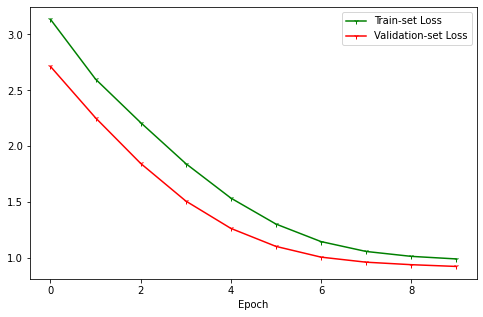

In [31]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))

plt.plot(data1.history['loss'], marker='1', c='green', label='Train-set Loss')
plt.plot(data1.history['val_loss'], marker='1', c='red', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### 문장생성

In [25]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

### 가사 생성

In [24]:
keywords = ['love', 'my love', 'I','me' ,'you', 'she', 'he', 'hello', 'no', 'you must','am','not']
for start in keywords:
    print(generate_text(model, tokenizer, init_sentence= ' '.join(["<start>", start])))

<start> love is a feeling <end> 
<start> my love she speaks softly <end> 
<start> i m not the one you want , babe <end> 
<start> me and my mama taking over <end> 
<start> you know i love you <end> 
<start> she s got the look <end> 
<start> he s the fairest of ten thousand to my soul <end> 
<start> hello , hello , hello , how low <end> 
<start> no matter how hard i try every turn i take <end> 
<start> you must be messed up too lay your head on my pillow <end> 
<start> am i scary for you oh <end> 
<start> not to <unk> thy passion , my humility . <end> 


# 회고
- 코드는 어느정도 이해 하였으나 조금더 공부가 필요할 것 같습니다..아직까지 제게 부족한 부분이 많이 보이고 코드를 실행 하면서도 이해도가 부족한 부분이 많은 것 같습니다. 하이퍼파라미터를 교체하면서 모델과 최적의 결과를 공부하는데 많은 도움이 된 것 같습니다.. 다만 모델을 실행함에 있어서 시간이 오래걸리는점이 조금 프로젝트하는데 조금에 에로사항이 아니었나 싶습니다.